This notebook shows how to extract the estimated normalized entropy rate (nER) formulated in [Tejedor et al.](https://www.pnas.org/content/114/44/11651) from our channel network. The wikipage for the nER (without the discussion of the normalization factor) is [here](https://en.wikipedia.org/wiki/Entropy_rate).

In [26]:
import rasterio
from rasterio.transform import array_bounds
import geopandas as gpd
from shapely.geometry import Point

import numpy as np
import matplotlib.pyplot as plt
import scipy

from pathlib import Path
from tqdm import tqdm
import networkx as nx

from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
from matplotlib import colors, colorbar, cm
from matplotlib.colors import LinearSegmentedColormap

from orinoco import (export_edges_to_geodataframe, 
                     export_nodes_to_geodataframe, 
                     dfs_line_search, 
                     direct_channel_network_using_distance,
                     get_cropped_profile)

In [2]:
map_name = 'stamen_terrain_12'  # options are `stamen_terrain_12` or `google_16`
data_path = Path(f'data/{map_name}')

In [3]:
product_dir = Path('products')
products_for_map_dir = product_dir/map_name
products_for_map_dir.exists()

True

In [4]:
plot_entropy = Path('plots/entropy')
plot_entropy.mkdir(exist_ok=True, parents=True)

In [5]:
chanG = nx.read_gpickle(products_for_map_dir/'channel_network.pkl')

In [6]:
edges_df = gpd.read_file(products_for_map_dir/'orinoco_edges.geojson')
nodes_df = gpd.read_file(products_for_map_dir/'orinoco_nodes.geojson')

# Obtain Directed Acyclic Network with Single Source

Let's select the node with the label we want (easier to specify label than node from QGIS due to precision issues).

In [7]:

label_value = 361
nodes_with_label = [node for node, data in chanG.nodes(data=True) if data['label'] == label_value]
nodes_with_label[0], len(nodes_with_label)

((655447.4137931034, 3280608.908045977), 1)

Using this SO [post](https://stackoverflow.com/a/13934101/2348348) from the original author of NetworkX, we can obtain the relevant subgraph.

In [8]:
source_node = nodes_with_label[0]
downstream_nodes = list(nx.shortest_path(chanG, source_node).keys())
chanG_sub = chanG.subgraph([source_node] + downstream_nodes).copy()
# Because some noddes are no longer junctions, this ensures the segments correspond to the current graph.
chanG_sub = direct_channel_network_using_distance(chanG_sub.to_undirected())

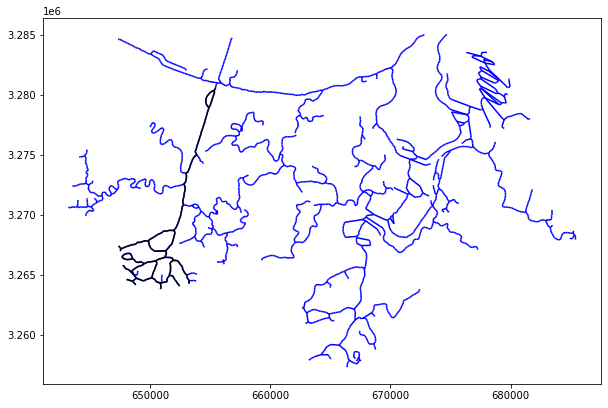

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

edges_df.plot(ax=ax, edgecolor='blue')

edges_df_sub = export_edges_to_geodataframe(chanG_sub, edges_df.crs)
nodes_df_sub = export_nodes_to_geodataframe(chanG_sub, edges_df.crs)

edges_df_sub.plot(ax=ax, edgecolor='black')

In [10]:
edges_df_sub.to_file('test')

In [11]:
# fig, ax = plt.subplots(figsize=(10, 10))
# nx.draw(chanG, 
#         pos=pos, 
#         node_size=1,
#         edge_width=.25,
#         alpha=.2,
#         arrows=True,
#         arrowsize=10,
#         ax=ax,
#         node_color='blue')
# nx.draw(chanG_sub, 
#         pos=pos, 
#         node_size=1,
#         arrows=True,
#         arrowsize=10,
#         ax=ax,
#         node_color='blue')


# Merge at Junctions

In [12]:
width_dict = nx.get_edge_attributes(chanG, 'width_m')
weight_dict = nx.get_edge_attributes(chanG, 'weight')

The depth-first search lines searches by edges and yields a list of edges in a partition.

In [13]:
lines = list(dfs_line_search(chanG_sub, source_node))

In [14]:
edge_data_merged = {(line[0][0], line[-1][1], k):  {'segment_id': k,
                                                    # Average width along edge segment
                                                    'width': np.mean([width_dict[edge] for edge in line]),
                                                    # Total Length of Line
                                                    'weight': np.sum([weight_dict[edge] for edge in line])}
                     for (k, line) in enumerate(lines)

                    }
current_edge_index = len(lines)
current_edge_index

31

In [15]:
chanG_merged = nx.MultiDiGraph()
chanG_merged.add_edges_from(edge_data_merged.keys())
nx.set_edge_attributes(chanG_merged, edge_data_merged)

In [16]:
pos = {node: node for node in chanG.nodes()}

In [17]:
source_node

(655447.4137931034, 3280608.908045977)

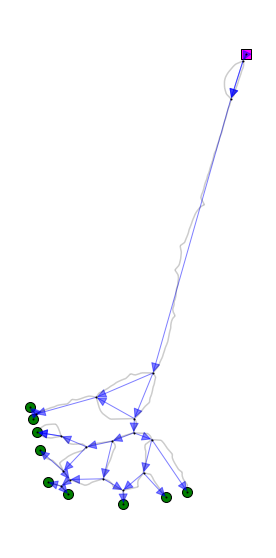

In [18]:
fig, ax = plt.subplots(figsize=(6, 10))


#edges_df.plot(ax=ax, edgecolor='black', alpha=.2)


nx.draw(chanG_merged, 
        pos=pos, 
        node_size=1,
        edge_width=.25,
        edge_color=[(0, 0, 1, .5)]*len(chanG_merged.edges()),
        arrows=True,
        arrowsize=20,
        ax=ax,
        node_color='black')

edges_df_sub.plot(ax=ax, edgecolor='black', alpha=.2)

nodes_df_sub[nodes_df_sub.interface_adj].plot(color='green', ax=ax, markersize=100, edgecolor='black')

nodes_df_source = export_nodes_to_geodataframe(chanG.subgraph([source_node]), nodes_df.crs)
nodes_df_source.plot(color='blue', ax=ax, markersize=100, facecolor='magenta', edgecolor='black', marker='s')




# Connect Source and Outlets

In [19]:
outlets = [node for node, data in chanG_sub.nodes(data=True) if data['interface_adj']]
len(outlets)

9

In [20]:
stationary_distribution_graph = chanG_merged.copy()
edges_outlet_to_source = [(outlet, source_node, k + current_edge_index) 
                            for k, outlet in enumerate(outlets)]
stationary_distribution_graph.add_edges_from(edges_outlet_to_source)
nx.set_edge_attributes(stationary_distribution_graph,
                      {edge: {'width': 1.} for edge in edges_outlet_to_source})
current_edge_index = len(lines) + len(outlets)

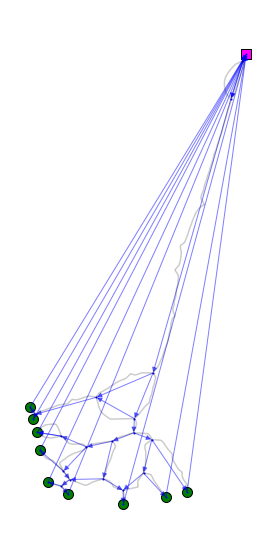

In [21]:
fig, ax = plt.subplots(figsize=(5, 10))



nx.draw(stationary_distribution_graph, 
        pos=pos, 
        node_size=1,
        edge_width=.25,
        edge_color=[(0, 0, 1, .5)]*len(stationary_distribution_graph.edges()),
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')
edges_df_sub.plot(ax=ax, edgecolor='black', alpha=.2)

nodes_df_sub[nodes_df_sub.interface_adj].plot(color='green', ax=ax, markersize=100, edgecolor='black')
nodes_df_source = export_nodes_to_geodataframe(chanG.subgraph([source_node]), nodes_df.crs)
nodes_df_source.plot(color='blue', ax=ax, markersize=100, facecolor='magenta', edgecolor='black', marker='s')

# Compute Stationary Distribution and nER

In [22]:
nodes_from_multigraph = list(stationary_distribution_graph.nodes())

In [23]:
stationary_distribution_graph_undirected = stationary_distribution_graph.to_directed()
adj_mat = nx.adj_matrix(stationary_distribution_graph_undirected, 
                        nodelist=nodes_from_multigraph,
                        weight='width')
transition_matrix = np.array((adj_mat / adj_mat.sum(axis=1)))

In [27]:
import warnings

def compute_normalized_entropy_rate(transition_matrix):
    eig_values, eig_vec_l, _ = scipy.linalg.eig(transition_matrix, left=True)
    pi = eig_vec_l[:, 0].real
    pi = (pi / np.sum(pi))
    
    #enusre largest eignvalue is 1
    assert(np.abs(eig_values[0] - 1) < 1e-10)
    # ensure eigenvector is real
    assert(np.linalg.norm(eig_vec_l[:, 0].astype(float) - eig_vec_l[:, 0]) < 1e-10)
    
    log_T = np.log(transition_matrix, where=(transition_matrix>0), out=np.zeros(transition_matrix.shape))
    deg = np.sum((transition_matrix > 0), axis=1)
    normalized_er = np.einsum('ij,ij->i', transition_matrix, log_T) 
    normalized_er /=  np.log(1./deg, where=(deg > 1), out=np.ones(deg.shape))
    normalized_er = np.dot(normalized_er, pi)
    return normalized_er

In [28]:
compute_normalized_entropy_rate(transition_matrix)

/Users/cmarshak/anaconda3/envs/orinoco_test/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


0.3974633680890047

# Plot for Report

In [33]:
products_for_map_dir_4326 = Path(f'{products_for_map_dir}_4326')


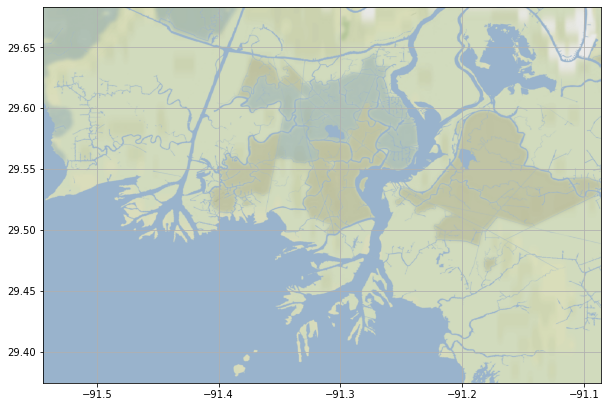

In [46]:
from rasterio import plot

fig, ax = plt.subplots(figsize=(10, 10))

with rasterio.open(products_for_map_dir_4326/'ocean_mask.tif') as ds:
    ocean_mask = ds.read(1)
    
with rasterio.open(products_for_map_dir_4326/'water_mask.tif') as ds:
    water_mask = ds.read(1)

with rasterio.open(products_for_map_dir_4326/f'{map_name}.tif') as ds:
    stamen_arr = ds.read()
    transform = ds.transform
    profile = ds.profile

plot.show(stamen_arr, ax=ax, transform=transform)
ax.grid('on', zorder=2)


In [63]:
sy, sx =  np.s_[:675], np.s_[100:775],
profile_c = get_cropped_profile(profile_4326, sx, sy)
transform_c = profile_c['transform']
x_min, y_min, x_max, y_max = array_bounds(profile_c['height'], 
                                          profile_c['width'], 
                                          profile_c['transform'])

In [64]:
edges_df_4326 = gpd.read_file(products_for_map_dir/'orinoco_edges.geojson').to_crs({'init':'epsg:4326'})
nodes_df_4326 = gpd.read_file(products_for_map_dir/'orinoco_nodes.geojson').to_crs({'init':'epsg:4326'})
nodes_df_source_4326 = nodes_df_source.to_crs({'init':'epsg:4326'})
edges_df_sub_4326 = edges_df_sub.to_crs({'init':'epsg:4326'})
nodes_df_sub_4326 = nodes_df_sub.to_crs({'init':'epsg:4326'})

/Users/cmarshak/anaconda3/envs/orinoco_test/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/cmarshak/anaconda3/envs/orinoco_test/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/cmarshak/anaconda3/envs/orinoco_test/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the 

In [65]:
H = chanG_sub.copy()

In [66]:
legend_elements = [Line2D([0], 
                          [0], 
                          marker='s',
                          color='w',
                          label=f'Source',
                          markerfacecolor='blue',
                          markeredgecolor='black',
                          alpha=1,
                          markersize=10)]

legend_elements += [Line2D([0], 
                           [0], 
                           marker='o',
                           color='w',
                           label=f'Outlet',
                           markerfacecolor='green',
                           markeredgecolor='black',
                           alpha=1,
                           markersize=10)]

legend_elements += [Line2D([0], 
                           [0], 
                           marker='>',
                           color='black',
                           markerfacecolor='blue',
                           markeredgecolor='blue',
                           label='Stream flow',
                           linewidth=1,
                           markersize=15)]
legend_elements += [Line2D([0], 
                           [0], 
                           marker=None,
                           color='black',
                           label='Subgraph',
                           linewidth=2,
                           markersize=10)]

legend_elements += [Line2D([0], 
                           [0], 
                           marker=None,
                           color='blue',
                           label='Full network',
                           linewidth=2,
                           markersize=10)]

In [67]:
# Slower, but equivalent

# from pyproj import Proj, transform
# inProj = Proj(init=original_crs)
# outProj = Proj(init='epsg:4326')
# pos_r = {node: transform(inProj,outProj,*node) for node in H.nodes()}

geom = list(map(lambda p: Point(*p), H.nodes()))
nodes_df_temp = gpd.GeoDataFrame(geometry=geom, crs=edges_df.crs)
nodes_df_temp['geometry_r'] = nodes_df_temp.geometry.to_crs({'init':'epsg:4326'})
nodes_df_temp['geometry_r_coords'] = nodes_df_temp['geometry_r'].map(lambda p: p.coords[0])
nodes_df_temp['geometry_coords'] = nodes_df_temp['geometry'].map(lambda p: p.coords[0])
nodes_df_temp.head()
pos_r = nodes_df_temp.set_index('geometry_coords').to_dict()['geometry_r_coords']

/Users/cmarshak/anaconda3/envs/orinoco_test/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [68]:
from orinoco import dfs_line_search

interface_nodes = [node for node, data in H.nodes(data=True) if data['interface_adj']]
node_data = dict(H.nodes(data=True))

def dfs_line_search_with_interface(G, source):
    def interface_criterion(node):
        return node_data[node]['interface_adj']
    return dfs_line_search(G, source, break_func=interface_criterion)

random_source = interface_nodes[0]
lines = list(dfs_line_search_with_interface(H.to_undirected(), random_source))

edges_with_arrows_0 = [line[len(line)//3] for line in lines 
                     if len(line) > 2]
edges_with_arrows_1 = [line[len(line)//3] for line in lines 
                     if (node_data[line[-1][0]]['interface_adj']) | (node_data[line[-1][1]]['interface_adj'])]
edges_with_arrows = edges_with_arrows_0 + edges_with_arrows_1
len(edges_with_arrows)

32

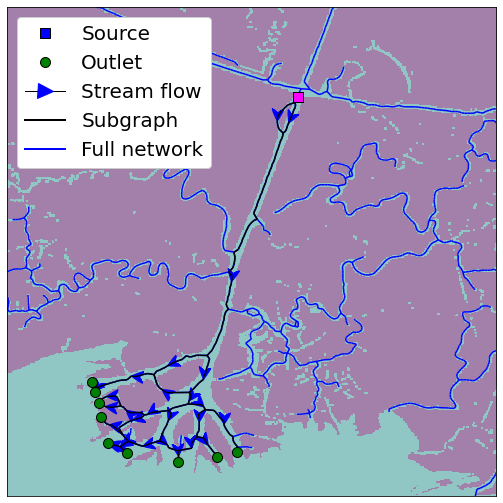

In [69]:
fig, ax = plt.subplots(figsize=(13, 9))
plot.show(water_mask[sy, sx], 
          ax=ax, 
          transform=transform_c, 
          zorder=0,  
          vmin=0, 
          vmax=2, 
          interpolation='none',
          alpha=.5)

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))



edges_df_4326.plot(ax=ax, edgecolor='blue', alpha=1)
edges_df_sub_4326.plot(ax=ax, edgecolor='black', alpha=1)
nodes_df_sub_4326[nodes_df_sub_4326.interface_adj].plot(color='green', ax=ax, markersize=100, edgecolor='black', zorder=3)

ins, outs = zip(*edges_with_arrows)
H2 = H.subgraph(list(set(ins + outs)))

nodes_df_source_4326.plot(color='blue', 
                          ax=ax, 
                          markersize=100, 
                          facecolor='magenta', 
                          edgecolor='black', 
                          marker='s', 
                          zorder=4)

nx.draw_networkx_edges(H2, 
                        pos=pos_r,
                        width=1.2,
                        edge_list=edges_with_arrows,
                        node_size=1,
                        arrows=True,
                        arrowstyle="fancy",
                        arrowsize=28,
                        ax=ax,
                        edge_color='blue',
                        zorder=1,
                        alpha=1,
                       )

ax.legend(handles=legend_elements, loc='upper left', fontsize=20,  framealpha=1)
plt.savefig(plot_entropy/'entropy_fig.png')